In [0]:
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/bitcoin_tweets.csv




--2025-03-18 17:08:37--  https://proai-datasets.s3.eu-west-3.amazonaws.com/bitcoin_tweets.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 3.5.205.181, 3.5.206.24
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|3.5.205.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24708828 (24M) [text/csv]
Saving to: ‘bitcoin_tweets.csv’

bitcoin_tweets.csv  100%[===================>]  23.56M  13.2MB/s    in 1.8s    

2025-03-18 17:08:39 (13.2 MB/s) - ‘bitcoin_tweets.csv’ saved [24708828/24708828]



Upload del dataset

In [0]:
%pip install textblob

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
%pip install langdetect


Python interpreter will be restarted.
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=06ebbc3a283baa3da0538d9fd6b127a172993c0bb0505f1e7589e57a9b9c229c
  Stored in directory: /root/.cache/pip/wheels/d1/c1/d9/7e068de779d863bc8f8fc9467d85e25cfe47fa5051fff1a1bb
Successfully built langdetect
Python interpreter will be restarted.


In [0]:
# Libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp, col, regexp_replace, lower, when, length, expr
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import explode, col, lag, avg, size, to_date, trim
from pyspark.sql.functions import array_intersect, split, lit, when, regexp_replace
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.window import Window
import seaborn as sns
from textblob import TextBlob
from langdetect import detect
from pyspark.sql import functions as F
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk


In [0]:
dataset = pd.read_csv('/databricks/driver/bitcoin_tweets.csv')


Testo l'upload

In [0]:
dataset.head()

,id,user,fullname,url,timestamp,replies,likes,retweets,text
0,1.132977e+18,KamdemAbdiel,Abdiel kamdem,NaN,2019-05-27 11:49:14+00,0.0,0.0,0.0,È appena uscito un nuovo video! LES CRYPTOMONN...
1,1.132977e+18,bitcointe,Bitcointe,NaN,2019-05-27 11:49:18+00,0.0,0.0,0.0,Cardano: Digitize Currencies; EOS https://t.co...
2,1.132977e+18,3eyedbran,Bran - 3 Eyed Raven,NaN,2019-05-27 11:49:06+00,0.0,2.0,1.0,Another Test tweet that wasn't caught in the s...
3,1.132977e+18,DetroitCrypto,J. Scardina,NaN,2019-05-27 11:49:22+00,0.0,0.0,0.0,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
4,1.132977e+18,mmursaleen72,Muhammad Mursaleen,NaN,2019-05-27 11:49:23+00,0.0,0.0,0.0,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...


Upload in spark

In [0]:
spark.sql("DROP TABLE IF EXISTS bitcoin_tweets")


Out[5]: DataFrame[]

In [0]:
spark_df = spark.createDataFrame(dataset)
spark_df.write.mode("overwrite").format("delta").save("dbfs:/user/hive/warehouse/bitcoin_tweets")

Analisi della forma

In [0]:
spark_df.printSchema()


root
 |-- id: double (nullable = true)
 |-- user: string (nullable = true)
 |-- fullname: string (nullable = true)
 |-- url: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- replies: double (nullable = true)
 |-- likes: double (nullable = true)
 |-- retweets: double (nullable = true)
 |-- text: string (nullable = true)



Analizzo tweet unici e duplicati

In [0]:
# Conta il numero totale di righe
total_rows = spark_df.count()

# Conta il numero di righe uniche (rimuovendo i duplicati)
unique_rows = spark_df.dropDuplicates(["text"]).count()

# Calcola il numero di duplicati
duplicate_count = total_rows - unique_rows

print(f"Totale tweet: {total_rows}")
print(f"Tweet unici: {unique_rows}")
print(f"Tweet duplicati: {duplicate_count}")


Totale tweet: 100001
Tweet unici: 94885
Tweet duplicati: 5116


Verifico la presenza di tweet di lunghezza poco significativa

In [0]:
spark_df.filter(length(col("text")) < 5).show()
short_tweet=spark_df.filter(length(col("text")) >= 5).count()
print(short_tweet)

+--------------------+---------------+--------------------+----+--------------------+-------+-----+--------+--------+
|                  id|           user|            fullname| url|           timestamp|replies|likes|retweets|    text|
+--------------------+---------------+--------------------+----+--------------------+-------+-----+--------+--------+
|1.132977185910870...|    sigizmundo8|           sigizmund|null|2019-05-27 11:49:...|    0.0|  0.0|     0.0|  🤣🤣🤣|
|1.126826102956204...|  thabubbajames|        Crypto Bubba|null|2019-05-10 10:27:...|    0.0|  0.0|     0.0|    😂😂|
|1.127004033162588...|    hao32927291|                 hao|null|2019-05-10 22:14:...|    0.0|  0.0|     0.0|    nice|
|1.126890051386912...|         TI__Ed|                TIED|null|2019-05-10 14:41:...|    0.0|  0.0|     0.0|     BTC|
|1.127004265858224E18|         birmas|              birmas|null|2019-05-10 22:15:...|    0.0|  0.0|     0.0|      👍|
|1.127045801769930...|       mironyan|          Yavruyan E|nul

Data Cleaning

In [0]:


# Rimozione delle colonne inutili
spark_df = spark_df.drop("fullname", "url","user")
#Rimuovere duplicati
spark_df = spark_df.dropDuplicates() 
# Pre-elaborazione del testo (pulizia): rimuovi URL, menzioni, simboli speciali, spazi inutili
spark_df = spark_df.withColumn(
    "cleaned_text",
    regexp_replace(
        regexp_replace(col("text"), r"http\S+|www.\S+|@\w+|[^a-zA-Z\s]|[\r\n]", " "), r"\s+", " " ))

spark_df = spark_df.withColumn("cleaned_text", lower(col("cleaned_text")))
# rimuovo eventuali tweet di lunghezza insignificante
spark_df = spark_df.filter(length(col("text")) >= 5)
#rimuovo la colonna text perchè la sostituisco con cleaned_text
spark_df = spark_df.drop("text")
# Conversione della colonna timestamp
spark_df = spark_df.withColumn("timestamp", to_timestamp("timestamp"))
# Mantengo solo la data, per l'esercizio ho bisogno di essa
spark_df = spark_df.withColumn("timestamp", to_date("timestamp"))




Verifico le modifiche

rinomino la colonna timestampe in date perchè mi servirà più avanti

In [0]:
spark_df = spark_df.withColumnRenamed("timestamp", "date")

converto il campo id in stringa er evitare eventuali problemi di calcolo con altri sistemi da cui probabilmente passerà il dataset.

In [0]:
# Convertire 'id' in formato string
spark_df = spark_df.withColumn("id", col("id").cast("string"))

Verifico che non ci siano tuple nulle

In [0]:
# Verifico tweet nulli
null_count = spark_df.filter(col("cleaned_text").isNull()).count()
null_count_date = spark_df.filter(col("date").isNull()).count()
print(f"Righe con valori nulli in cleaned_text dopo la pulizia: {null_count}")
print(f"Righe con valori nulli in date dopo la pulizia: {null_count_date}")
# Verifico la dimensione del dataset dopo la pulizia
print(f"Numero di righe post pulizia: {spark_df.count()}")

Righe con valori nulli in cleaned_text dopo la pulizia: 0
Righe con valori nulli in timestamp dopo la pulizia: 0
Numero di righe post pulizia: 99574


In [0]:
#creo una copia del df in spark, lo utilizzo come checkpoint in caso di errori futuri
spark_df_cleaned = spark_df.select("*")

- procedo con la rimozione delle stopwords, essendo multilingua scarico le stopwords inerenti a più lingue
- per evitare l'utilizzo di udf e snellire i processi decido di usare questo metodo per velocizzare i l'esecuzione dei blocchi di codice

In [0]:
# Stopwords multilingua
stopwords_multilang = {
    "en": ["the", "is", "in", "and", "to", "for", "with", "a", "of"],
    "es": ["el", "la", "es", "en", "y", "para", "con", "un", "de"],
    "fr": ["le", "la", "est", "et", "pour", "avec", "un", "de"],
}

# Stopwords personalizzate
# Stopwords aggiuntive personalizzate
additional_stopwords = ["bitcoin", "btc", "crypto", "price", "blockchain", "cryptocurrency", "ethereum", "eth",
    "\n", "market", "time", "like", "binance", "free", "top", "new", "k","imm"]

# Converte le stopwords in array di Spark SQL
stopwords_expr = {lang: "array({})".format(", ".join(['"{}"'.format(word) for word in words]))
                  for lang, words in stopwords_multilang.items()}
additional_stopwords_expr = "array({})".format(", ".join(['"{}"'.format(word) for word in additional_stopwords]))

# Tokenizza il testo in parole
spark_df_cleaned = spark_df.withColumn("words", split(col("cleaned_text"), " "))

# **Rimozione delle stopwords con Spark SQL**
spark_df = spark_df.withColumn(
    "filtered_words",
    expr("""
        filter(words, word -> 
            NOT array_contains({}, word) AND 
            NOT array_contains({}, word) AND 
            NOT array_contains({}, word) AND
            NOT array_contains({}, word)
        )
    """.format(stopwords_expr.get('en'),
               stopwords_expr.get('es'),
               stopwords_expr.get('fr'),
               additional_stopwords_expr))
)

# Ricostruisce il testo senza stopwords
spark_df_cleaned = spark_df_cleaned.withColumn("cleaned_text", expr("concat_ws(' ', filtered_words)"))

# Rimuove colonne temporanee
spark_df_cleaned = spark_df_cleaned.drop("words", "filtered_words")

# Mostra il risultato finale
spark_df_cleaned.select("cleaned_text").show(truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|cleaned_text                                                                                                                                                                                                |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| line xrp                                                                                                                                                                                                   |
|one useful articles stefan here guide you can run node on alibaba cloud ltonetwork lto xrpcommmunity xlm xrp xrpcommmunity eos xmr trx ltc enjin                           

Ri-eseguo una pulizia dopo la tokenizzazione

In [0]:
#rimuovo righe dove clean_text è vuoto
spark_df_cleaned = spark_df_cleaned.filter(col("cleaned_text").rlike(r"\S+"))
# rimuovo eventuali tweet di lunghezza insignificante
spark_df_cleaned = spark_df.filter(length(col("cleaned_text")) >= 5)

Testo il blocco precedente con i primi 10 risultati per impiegare meno tempo per i check

Per l'analisi del sentiment utilizzo TextBlob

In [0]:
# Funzione per calcolare il sentiment con TextBlob
def get_sentiment(text):
    if text:
        analysis = TextBlob(text)  # Analizza il testo
        polarity = analysis.sentiment.polarity  # Score tra -1 (negativo) e 1 (positivo)
        if polarity > 0:
            return "positive"
        elif polarity < 0:
            return "negative"
        else:
            return "neutral"
    return "neutral"

# Creazione della UDF (User Defined Function) per PySpark
get_sentiment_udf = udf(get_sentiment, StringType())

# Applicazione della sentiment analysis alla colonna "cleaned_text"
spark_df_cleaned = spark_df_cleaned.withColumn("sentiment", get_sentiment_udf(spark_df["cleaned_text"]))



# Mostra i risultati
spark_df_cleaned.select("cleaned_text", "sentiment").show(truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|cleaned_text                                                                                                                                                                                                                                |sentiment|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
| great ways for absolute beginners to learn about bitcoin btc news aggregated by crypto cryptocurrency cryptonews                                                                                                                           |positive |
|bit

Testo il risultato del sentiment

Raggruppo in base alla distribuzione giornaliera

In [0]:
#creo una copia checkpoint
sentiment_by_day = spark_df_cleaned.select("*")

In [0]:


# Calcola la distribuzione del sentiment su base giornaliera
sentiment_by_day = sentiment_by_day.groupBy("date", "sentiment").count()

# Mostra i risultati
sentiment_by_day.show()

+----------+---------+-----+
|      date|sentiment|count|
+----------+---------+-----+
|2018-11-08| positive|    3|
|2019-04-20| positive|   11|
|2018-07-23| positive|    3|
|2018-10-20| positive|    3|
|2018-09-03|  neutral|    5|
|2019-04-19|  neutral|    7|
|2018-04-09|  neutral|    5|
|2018-04-14|  neutral|    3|
|2018-10-16| positive|    4|
|2018-06-26|  neutral|    3|
|2018-03-05| negative|    1|
|2018-04-28| positive|    1|
|2018-01-22|  neutral|    2|
|2017-12-03|  neutral|    4|
|2019-05-06| negative|    4|
|2018-07-09|  neutral|    7|
|2019-05-12| negative|   85|
|2018-01-01|  neutral|    1|
|2019-05-08| negative|   20|
|2019-05-13| positive|   49|
+----------+---------+-----+
only showing top 20 rows



Creo un grafico che mostri la distribzione nel tempo

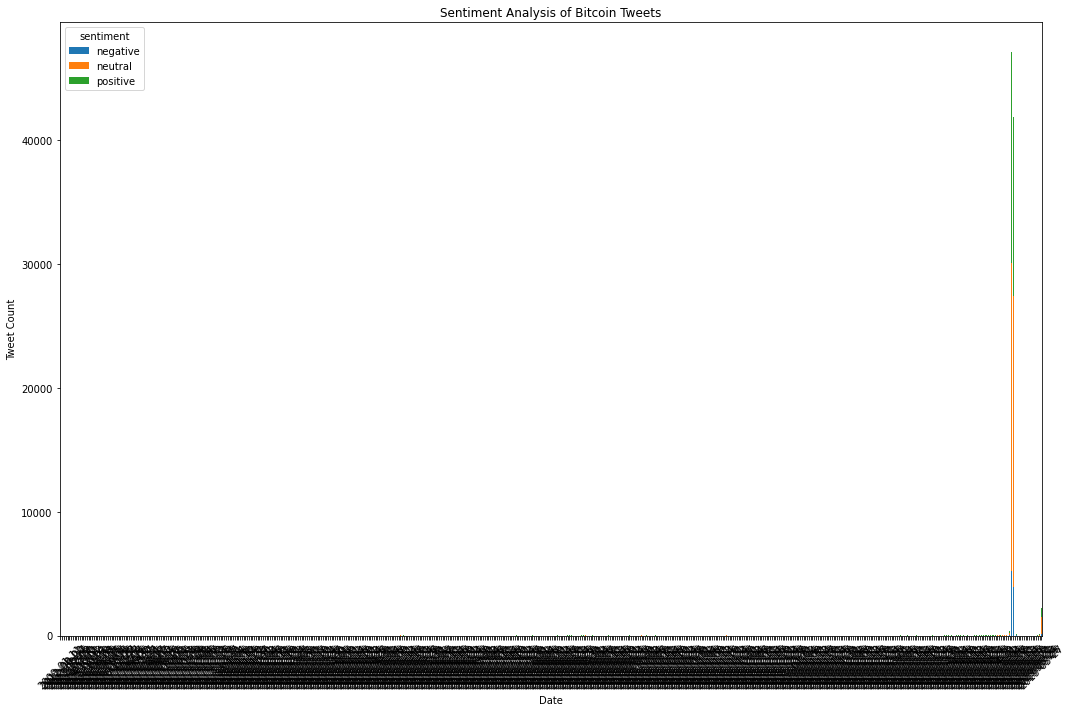

In [0]:

# Converti il DataFrame Spark in un DataFrame Pandas per visualizzazione
sentiment_pd = sentiment_by_day.toPandas()

# Pivot per avere le date come indice e i sentiment come colonne
sentiment_pivot = sentiment_pd.pivot_table(index="date", columns="sentiment", values="count", aggfunc="sum", fill_value=0)

# Grafico
sentiment_pivot.plot(kind="bar", stacked=True, figsize=(15, 10))
plt.title("Sentiment Analysis of Bitcoin Tweets")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


è evidente che il grafico non è fatto per bene e lo prendo come primo test

Rimuovo gli outlier

In [0]:
#per eliminare gli outlier filtro le date per quantità di tweet
tweet_counts_by_date = spark_df_cleaned.groupBy("date").agg(F.count("*").alias("count"))
tweet_counts_by_date.show(50)


+----------+-----+
|      date|count|
+----------+-----+
|2019-05-08|  180|
|2018-08-10|    5|
|2018-10-05|    6|
|2018-08-11|    9|
|2018-09-01|   11|
|2018-06-26|    4|
|2019-05-27| 2197|
|2019-01-08|    4|
|2018-05-26|    1|
|2018-09-08|   10|
|2019-04-28|   15|
|2018-08-31|   14|
|2017-12-25|    3|
|2019-03-14|    9|
|2019-05-14|    7|
|2017-12-08|    1|
|2019-03-26|   13|
|2018-10-04|   18|
|2018-05-27|    4|
|2019-03-28|    7|
|2016-09-26|    2|
|2019-05-10|47131|
|2018-06-27|    8|
|2019-01-26|    3|
|2018-01-08|    2|
|2018-10-09|    9|
|2018-12-30|    3|
|2018-09-30|   10|
|2018-09-19|    7|
|2018-10-07|   11|
|2018-01-14|    7|
|2017-12-04|   10|
|2018-04-14|    6|
|2019-03-29|   10|
|2019-05-13|  103|
|2018-02-04|    3|
|2017-12-03|    4|
|2018-06-24|    9|
|2019-03-19|    9|
|2019-05-12|  889|
|2018-07-08|    9|
|2018-07-03|    7|
|2019-05-04|   43|
|2018-07-18|    8|
|2018-09-11|   10|
|2018-12-06|    5|
|2018-10-15|   10|
|2018-10-01|    8|
|2019-02-19|    2|
|2019-01-19|

In [0]:
#per eliminare gli outlier filtro le date per quantità di tweet
tweet_counts_by_date = spark_df_cleaned.groupBy(spark_df_cleaned["date"].cast("date").alias("date")).count().orderBy("date")
tweet_counts_by_date.show(50)

tweet_counts_by_date = spark_df_cleaned.groupBy(spark_df_cleaned["date"].cast("date").alias("date")).count()
soglia = 15000  # Numero massimo di tweet consentiti per data
date_valid = tweet_counts_by_date.filter(col("count") <= soglia).select("date")
df_to_join = spark_df_cleaned.join(
    date_valid, 
    spark_df_cleaned["date"].cast("date") == date_valid["date"], 
    "inner"
).drop(date_valid["date"])

+----------+-----+
|      date|count|
+----------+-----+
|2009-01-11|    1|
|2012-08-02|    1|
|2012-09-20|    1|
|2012-11-17|    1|
|2013-08-16|    1|
|2013-12-09|    1|
|2013-12-19|    1|
|2013-12-20|    1|
|2014-02-20|    1|
|2014-07-12|    1|
|2014-08-01|    1|
|2014-10-03|    1|
|2014-12-12|    1|
|2015-02-14|    1|
|2015-09-02|    1|
|2015-10-21|    1|
|2015-11-19|    1|
|2016-02-19|    1|
|2016-03-28|    3|
|2016-05-03|    2|
|2016-05-15|    1|
|2016-05-19|    2|
|2016-05-25|    1|
|2016-06-15|    3|
|2016-06-16|    3|
|2016-07-07|    1|
|2016-09-09|    3|
|2016-09-26|    2|
|2016-09-29|    2|
|2016-10-06|    1|
|2016-11-29|    1|
|2016-12-27|    1|
|2017-01-04|    1|
|2017-01-27|    1|
|2017-02-04|    1|
|2017-02-06|    1|
|2017-05-24|    1|
|2017-05-25|    1|
|2017-06-06|    1|
|2017-06-22|    1|
|2017-06-30|    1|
|2017-07-17|    1|
|2017-07-21|    1|
|2017-07-27|    1|
|2017-07-28|    2|
|2017-07-31|    1|
|2017-08-05|    1|
|2017-08-09|    1|
|2017-08-17|    1|
|2017-08-22|

Per una migliore visualizzazione del grafico filtro l'intervallo temprale

In [0]:
# Filtra l'intervallo temporale (ad esempio, solo 2018-2019)
df_to_join = df_to_join.filter((df["date"] >= "2018-01-01") & (df_to_join["date"] <= "2019-12-31"))

In [0]:
df_filtered = df_to_join.select("*")

In [0]:
# Raggruppamento giornaliero dei sentiment

daily_sentiment_cleaned = df_filtered.groupBy(F.col("date").cast("date").alias("date"), "sentiment").agg(F.count("*").alias("count"))
daily_sentiment_aggregated = daily_sentiment_cleaned.select("*")
# Conversione in Pandas per il grafico
daily_sentiment_cleaned_pd = daily_sentiment_cleaned.toPandas()

# Pivot per creare un formato adatto al grafico
pivot_cleaned_df = daily_sentiment_cleaned_pd.pivot(index="date", columns="sentiment", values="count").fillna(0)
pivot_cleaned_df_to_join = daily_sentiment_aggregated.groupBy("date").pivot("sentiment").agg(F.first("count"))


testo la distribuzione

<Figure size 1008x504 with 0 Axes>

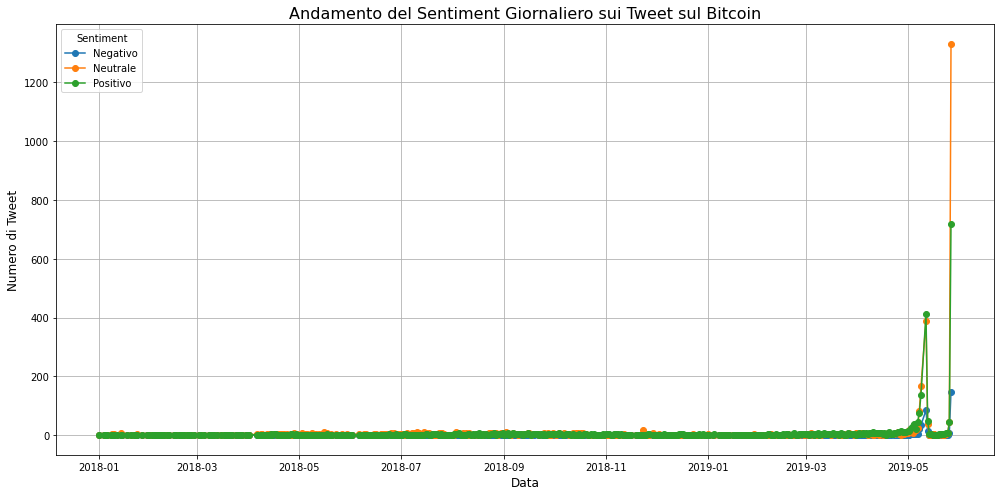

In [0]:
filtered_pivot_df = pivot_cleaned_df.copy()


# Creazione del grafico aggiornato senza outlier
plt.figure(figsize=(14, 7))
filtered_pivot_df.plot(kind="line", figsize=(14, 7), marker="o")
plt.title("Andamento del Sentiment Giornaliero sui Tweet sul Bitcoin", fontsize=16)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Numero di Tweet", fontsize=12)
plt.legend(title="Sentiment", labels=["Negativo", "Neutrale", "Positivo"])
plt.grid()
plt.tight_layout()
plt.show()

noto che la maggior parte dei valori sta al di sotto dei 200 quindi decido di abbassare il valore di soglia a 200 

<Figure size 1008x504 with 0 Axes>

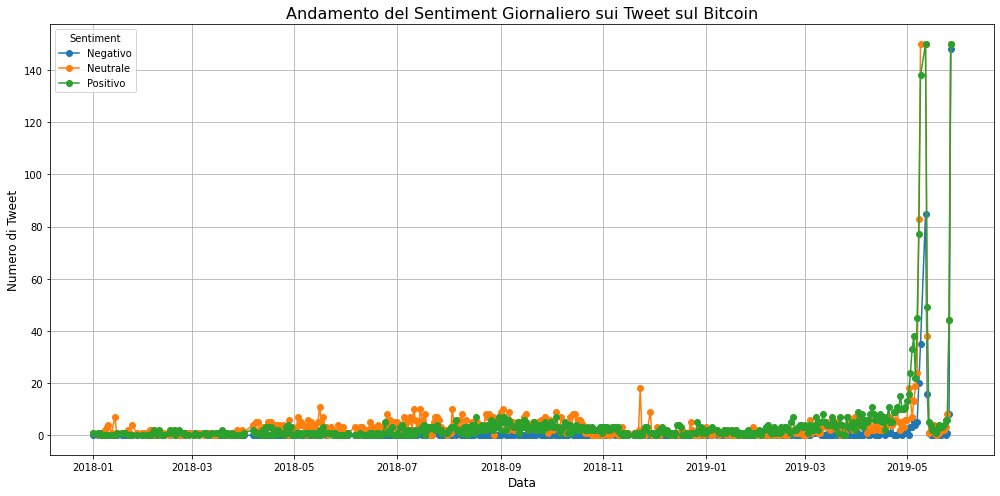

In [0]:
# Rimuovi outlier sopra 150 tweet
filtered_pivot_df = pivot_cleaned_df.copy()
filtered_pivot_df['neutral'] = filtered_pivot_df['neutral'].apply(lambda x: min(x, 150))
filtered_pivot_df['positive'] = filtered_pivot_df['positive'].apply(lambda x: min(x, 150))

# Creazione del grafico aggiornato 
plt.figure(figsize=(14, 7))
filtered_pivot_df.plot(kind="line", figsize=(14, 7), marker="o")
plt.title("Andamento del Sentiment Giornaliero sui Tweet sul Bitcoin", fontsize=16)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Numero di Tweet", fontsize=12)
plt.legend(title="Sentiment", labels=["Negativo", "Neutrale", "Positivo"])
plt.grid()
plt.tight_layout()
plt.show()

+---------+-----------------+
|sentiment|    average_likes|
+---------+-----------------+
| positive| 65.7473604826546|
| negative|107.3195020746888|
+---------+-----------------+



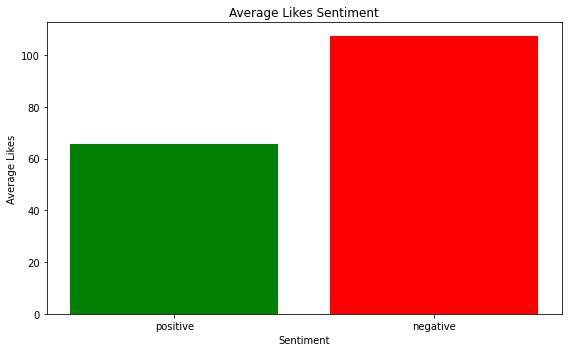

In [0]:
# Calcolo delle medie di likes per i tweet negativi e positivi
engagement_analysis = (
    df_filtered.groupBy("sentiment")
    .agg({"likes": "mean"})
    .withColumnRenamed("avg(likes)", "average_likes")
    .filter(col("sentiment").isin("positive", "negative"))
)

# Visualizza i risultati
engagement_analysis.show()

# Conversione in Pandas per un confronto visivo
engagement_analysis_pd = engagement_analysis.toPandas()

# Creazione di un grafico a barre
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(engagement_analysis_pd["sentiment"], engagement_analysis_pd["average_likes"], color=["green", "red"])
plt.title("Average Likes Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Likes")
plt.tight_layout()
plt.show()


Sulla base dei risultati sembra che i tweet negativi riscuotino più like

+---------+------------------+
|sentiment|   average_replies|
+---------+------------------+
| positive|10.440045248868778|
| negative| 11.45435684647303|
+---------+------------------+



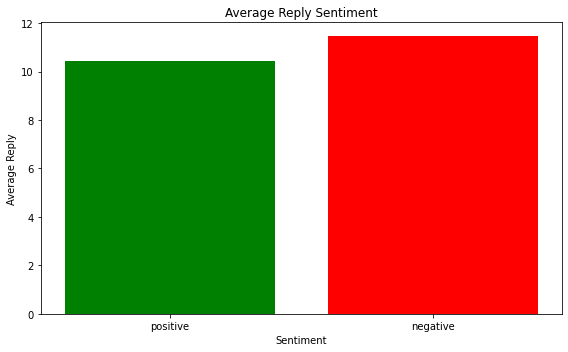

In [0]:
# Calcolo delle medie di likes per i tweet negativi e positivi
interazioni_analysis = (
    df_filtered.groupBy("sentiment")
    .agg({"replies": "mean"})
    .withColumnRenamed("avg(replies)", "average_replies")
    .filter(col("sentiment").isin("positive", "negative"))
)

# Visualizza i risultati
interazioni_analysis.show()

# Conversione in Pandas per un confronto visivo
interazioni_analysis_pd = interazioni_analysis.toPandas()

# Creazione di un grafico a barre
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(interazioni_analysis_pd["sentiment"], interazioni_analysis_pd["average_replies"], color=["green", "red"])
plt.title("Average Reply Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Reply")
plt.tight_layout()
plt.show()


Sulla base dei risultati sembra che i tweet negativi riscuotino ricevano più risposte

Il sentiment pubblico verso il Bitcoin ha un'influenza sul prezzo della criptovaluta? O viceversa, i cambiamenti di prezzo influenzano il sentiment sui social media?

In [0]:
#importo il csv scaricato da kaggle per la comparazione
# File location and type
file_location = "dbfs:/FileStore/tables/Bitcoin.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

btc_prices = spark.read.format(file_type) \
   .option("header", "true") \
   .option("inferSchema", "true") \
   .option("sep", delimiter) \
   .load(file_location)

display(btc_prices)

Date,Open,High,Low,Close,Adj Close,Volume
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.79599,394.79599,37919700
2014-09-20,394.673004,423.29599,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181,398.821014,398.821014,26580100
2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600
2014-09-23,402.09201,441.557007,396.196991,435.790985,435.790985,45099500
2014-09-24,435.751007,436.112,421.131989,423.204987,423.204987,30627700
2014-09-25,423.156006,423.519989,409.467987,411.574005,411.574005,26814400
2014-09-26,411.428986,414.937988,400.009003,404.424988,404.424988,21460800


In [0]:
btc_prices.printSchema()


root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: long (nullable = true)



In [0]:
# Seleziona solo la colonna di interesse e rinomina
btc_prices = btc_prices.select(
    col("date"),
    col("close"),
    col("open")
)


# Mostra i risultati per verifica
btc_prices.show(10)
btc_prices.printSchema()

+----------+----------+----------+
|      date|     close|      open|
+----------+----------+----------+
|2014-09-17|457.334015|465.864014|
|2014-09-18|424.440002|456.859985|
|2014-09-19| 394.79599|424.102997|
|2014-09-20|408.903992|394.673004|
|2014-09-21|398.821014|408.084991|
|2014-09-22|402.152008|399.100006|
|2014-09-23|435.790985| 402.09201|
|2014-09-24|423.204987|435.751007|
|2014-09-25|411.574005|423.156006|
|2014-09-26|404.424988|411.428986|
+----------+----------+----------+
only showing top 10 rows

root
 |-- date: date (nullable = true)
 |-- close: double (nullable = true)
 |-- open: double (nullable = true)



In [0]:
df_to_compare = pivot_cleaned_df_to_join.select("*")


Effettuo il join tra il  dataset pulito e il dataset scaricato da kaggle

In [0]:
#Effettua il join basato sulla colonna "date"
combined_data = btc_prices.join(df_to_compare, "date", "inner")

# Visualizza i dati combinati
combined_data.show(10, truncate=False)


+----------+-----------+-----------+--------+-------+--------+
|date      |close      |open       |negative|neutral|positive|
+----------+-----------+-----------+--------+-------+--------+
|2019-05-08|5982.45752 |5849.481445|20      |83     |77      |
|2018-08-10|6184.709961|6571.419922|null    |2      |3       |
|2018-05-28|7135.990234|7371.310059|null    |2      |null    |
|2018-03-17|7916.879883|8321.910156|null    |1      |1       |
|2018-06-06|7653.97998 |7625.970215|null    |3      |null    |
|2018-06-26|6093.669922|6253.549805|null    |3      |1       |
|2018-09-01|7193.25    |7044.810059|null    |9      |2       |
|2018-08-11|6295.72998 |6185.790039|null    |6      |3       |
|2018-10-05|6622.47998 |6574.149902|null    |3      |3       |
|2018-11-02|6388.439941|6378.919922|null    |1      |3       |
+----------+-----------+-----------+--------+-------+--------+
only showing top 10 rows

+----------+
|date      |
+----------+
|2014-09-17|
|2014-09-18|
|2014-09-19|
|2014-09-20|
|

In [0]:
combined_data.show()

+----------+-----------+-----------+--------+-------+--------+
|      date|      close|       open|negative|neutral|positive|
+----------+-----------+-----------+--------+-------+--------+
|2019-05-08| 5982.45752|5849.481445|      20|     83|      77|
|2018-08-10|6184.709961|6571.419922|    null|      2|       3|
|2018-10-05| 6622.47998|6574.149902|    null|      3|       3|
|2018-08-11| 6295.72998|6185.790039|    null|      6|       3|
|2018-09-01|    7193.25|7044.810059|    null|      9|       2|
|2018-06-26|6093.669922|6253.549805|    null|      3|       1|
|2019-05-27| 8805.77832|8674.072266|     148|   1331|     718|
|2019-01-08|  4030.8479|4028.472168|    null|      2|       2|
|2018-05-26|7355.879883| 7486.47998|       1|   null|    null|
|2018-09-08| 6225.97998|6460.169922|       2|      5|       3|
|2019-04-28| 5285.13916|5271.746582|    null|      5|      10|
|2018-08-31|7037.580078|6973.970215|    null|      7|       7|
|2019-03-14|3924.369141|3905.576904|    null|      5|  

In [0]:
# Definisci una finestra per calcolare le variazioni
window_spec = Window.orderBy("date")

# variazione percentuale del prezzo di chiusura
combined_data = combined_data.withColumn("Var_pct",((col("close") - lag("close").over(window_spec)) / lag("close").over(window_spec)) * 100)



In [0]:
# Calcola le variazioni percentuali per i sentimenti
combined_data = combined_data.withColumn(
    "positive_change",
    ((col("positive") - lag("positive").over(window_spec)) / lag("positive").over(window_spec)) * 100
).withColumn(
    "negative_change",
    ((col("negative") - lag("negative").over(window_spec)) / lag("negative").over(window_spec)) * 100
).withColumn(
    "neutral_change",
    ((col("neutral") - lag("neutral").over(window_spec)) / lag("neutral").over(window_spec)) * 100
)


# Sostituisci i valori NULL con 0


In [0]:
combined_data = combined_data.fillna({
    "Var_pct": 0,
    "positive_change": 0,
    "negative_change": 0,
    "neutral_change": 0
})

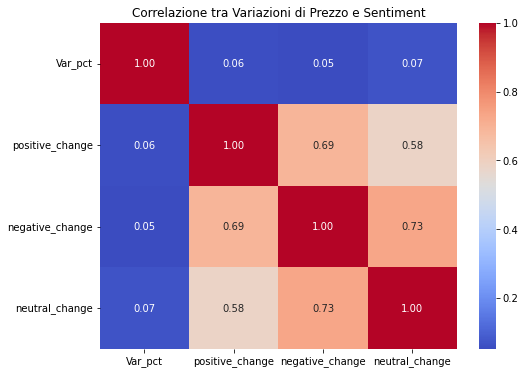

In [0]:
# Calcola la correlazione tra variazioni di prezzo e sentiment
correlation_data = combined_data.select(
    col("Var_pct"),
    col("positive_change"),
    col("negative_change"),
    col("neutral_change")
)

# Converti in Pandas per calcolare la matrice di correlazione
correlation_matrix = correlation_data.toPandas().corr()

# Visualizza la matrice di correlazione

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlazione tra Variazioni di Prezzo e Sentiment")
plt.show()


Conlcusioni
-  La correlazione tra variazioni di prezzo (var_pct) e sentiment positivo (positive_change): è molto debole 0.06, quindi si evince che non vi è una forte correlazione tra il sentimento positivo  e l'andamento di prezzo.
- Correlazione tra variazioni di prezzo (var_pct) e sentiment negativo (negative_change): ha un peso notevole 0.69, da cui si evince una forte influenza sull'andamento del sentiment legato al prezzo del bitcoin.
- Correlazione tra variazioni di prezzo (var_pct) e sentiment neutrale (neutral_change): 0.07 ha un peso pressochè nullo quindi possiamo dedurre che la variazione minima del prezzo non influirà sull'andamento del sentiment 

"I cambiamenti di prezzo influenzano il sentiment sui social media?"
- Non tutti i cambiamenti influenzano il sentiment, i più pesati sono i cambiamenti in negativo, infatti un andamento negativo influisce molto sul sentiment.